In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split
from torch import nn

# Load data and create datasets

In [2]:
batch_size = 512
datastore = h5py.File('trials6.h5', 'r')
data_I = torch.tensor(np.array(datastore["I"]))
data_c = torch.tensor(np.array(datastore["c"]))
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
# device = "cpu"
print(f"Using {device} device")

Using mps device


Input data consists of I values, followed by a t value where c(t) is the output. So we will use every row in `I` combined with the first time value, then every row in `I` combined with the second time value, and so on. There will be (40000)(101) samples now.

In [3]:
class DeepOLoader(Dataset):
    def __init__(self, I, c, device):
        self.times = torch.tensor(np.linspace(0, 1, I.shape[1], dtype=np.float32)).to(device)
        self.intensity = I.to(device)
        self.osmolarity = c.to(device)

    def __len__(self):
        return np.prod(self.intensity.shape)
    
    def reference(self, idx):
        ns, nt = self.intensity.shape
        return idx // ns, idx % ns  # time index, sample index

    def __getitem__(self, idx):
        return self.getitem(idx)
    
    def getitem(self, idx):
        idxt, idxs = self.reference(idx)
        x = torch.cat((self.intensity[idxs, :], self.times[idxt:idxt+1]))
        return x, self.osmolarity[idxs, idxt]

In [4]:
dataset = DeepOLoader(data_I, data_c, device)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the model

In [8]:
class Trunk(nn.Module):
    def __init__(self, width):
        super(Trunk, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, width),
            nn.Tanh(),
            nn.Linear(width, width),
            nn.Tanh(),
            nn.Linear(width, width),
            nn.Tanh(),
            nn.Linear(width, width))
        
    def forward(self, x):
        return self.layers(x)

class Branch(nn.Module):
    def __init__(self, width):
        super(Branch, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(101, width),
            nn.Tanh(),
            nn.Linear(width, width),
            nn.Tanh(),
            nn.Linear(width, width),
            nn.Tanh(),
            nn.Linear(width, width))
        
    def forward(self, x):
        return self.layers(x)

class DeepO(nn.Module):
    def __init__(self, trunk_width, branch_width):
        super().__init__()
        self.trunk = Trunk(trunk_width)
        self.branch = Branch(branch_width)

    def forward(self, x):
        t = self.trunk(x[:, -1:])
        b = self.branch(x[:, :-1])
        return torch.multiply(t, b).sum(dim=1)

In [9]:
model = DeepO(80, 80).to(device)
print(model)

DeepO(
  (trunk): Trunk(
    (layers): Sequential(
      (0): Linear(in_features=1, out_features=80, bias=True)
      (1): Tanh()
      (2): Linear(in_features=80, out_features=80, bias=True)
      (3): Tanh()
      (4): Linear(in_features=80, out_features=80, bias=True)
      (5): Tanh()
      (6): Linear(in_features=80, out_features=80, bias=True)
    )
  )
  (branch): Branch(
    (layers): Sequential(
      (0): Linear(in_features=101, out_features=80, bias=True)
      (1): Tanh()
      (2): Linear(in_features=80, out_features=80, bias=True)
      (3): Tanh()
      (4): Linear(in_features=80, out_features=80, bias=True)
      (5): Tanh()
      (6): Linear(in_features=80, out_features=80, bias=True)
    )
  )
)


## Test model on an input

In [10]:
model( next(iter(train_dataloader))[0] )

tensor([ 0.0811,  0.0243,  0.0549,  0.1003,  0.0671, -0.0007,  0.0451,  0.1051,
         0.0511,  0.0363,  0.0189,  0.0305,  0.0950,  0.0049,  0.0720, -0.0140,
         0.0519, -0.0081,  0.0215, -0.0133,  0.1090, -0.0835, -0.0740,  0.0228,
         0.0338, -0.0592,  0.1099,  0.1197,  0.0021,  0.1096, -0.0162,  0.0131,
         0.0752,  0.0767,  0.0631,  0.0565,  0.0807,  0.0034,  0.0386,  0.0669,
        -0.0807,  0.0360,  0.0679,  0.0354, -0.0717,  0.0590, -0.0793,  0.0152,
         0.0055,  0.0957,  0.1098,  0.0446,  0.0129, -0.0499,  0.0089,  0.0874,
        -0.0269, -0.0303,  0.0750,  0.0127, -0.0744,  0.0732,  0.0881,  0.0459,
        -0.0655,  0.0229, -0.0756,  0.0035,  0.0192,  0.0550, -0.0208,  0.0469,
         0.0845,  0.0627, -0.0151, -0.0060, -0.0565,  0.0580,  0.0529,  0.1253,
         0.0118,  0.0051,  0.0289,  0.0511,  0.0573,  0.0029,  0.0129,  0.0542,
        -0.0948, -0.0026,  0.0798, -0.0870,  0.0853,  0.0833,  0.0102,  0.0112,
         0.0488,  0.0337, -0.0181,  0.04

# Training

In [11]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

    test_loss /= num_batches
    print(f"Test Error: Avg loss = {test_loss:>8f} \n")

In [70]:
learning_rate = 1e-3
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
epochs = 1
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.021394  [  512/3232000]
loss: 0.029830  [51712/3232000]
loss: 0.030479  [102912/3232000]
loss: 0.031235  [154112/3232000]
loss: 0.015313  [205312/3232000]
loss: 0.023399  [256512/3232000]
loss: 0.030178  [307712/3232000]
loss: 0.032724  [358912/3232000]
loss: 0.046953  [410112/3232000]
loss: 0.030933  [461312/3232000]
loss: 0.028859  [512512/3232000]
loss: 0.028859  [563712/3232000]
loss: 0.040550  [614912/3232000]
loss: 0.034671  [666112/3232000]
loss: 0.018209  [717312/3232000]
loss: 0.030751  [768512/3232000]
loss: 0.016841  [819712/3232000]
loss: 0.021218  [870912/3232000]
loss: 0.039953  [922112/3232000]
loss: 0.043373  [973312/3232000]
loss: 0.038477  [1024512/3232000]
loss: 0.031389  [1075712/3232000]
loss: 0.033017  [1126912/3232000]
loss: 0.030377  [1178112/3232000]
loss: 0.021708  [1229312/3232000]
loss: 0.028322  [1280512/3232000]
loss: 0.037062  [1331712/3232000]
loss: 0.021938  [1382912/3232000]
loss: 0.025823  [1434112/32320

# Inspecting results

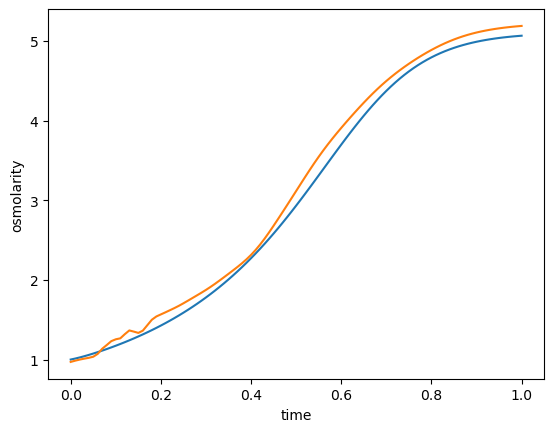

In [71]:
samp = 11111
t = np.linspace(0, 1, 101, dtype=np.float32)
with torch.no_grad():
    pred = [model(torch.cat((data_I[samp:samp+1], torch.tensor(t).reshape(-1, 1)), dim=1).to(device)).cpu().numpy() for t in t]

plt.plot(np.linspace(0, 1, 101), data_c[samp].cpu().numpy(), label="exact")
plt.plot(t, pred, label="predicted")
plt.xlabel("time")
plt.ylabel("osmolarity")
plt.show()

In [72]:
with torch.no_grad():
    pred_c = np.zeros(data_c.shape, np.float32)
    for (j, tj) in enumerate(np.linspace(0, 1, 101, dtype=np.float32)):
        pred = model(torch.cat((data_I, torch.tensor(tj).repeat((data_I.shape[0],1))),1).to(device)).cpu()
        pred_c[:, j] = pred


/var/folders/y5/mgf703t57tx9cwrbbjjvdzzr0000gr/T/ipykernel_31567/3462213975.py:5: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  pred_c[:, j] = pred


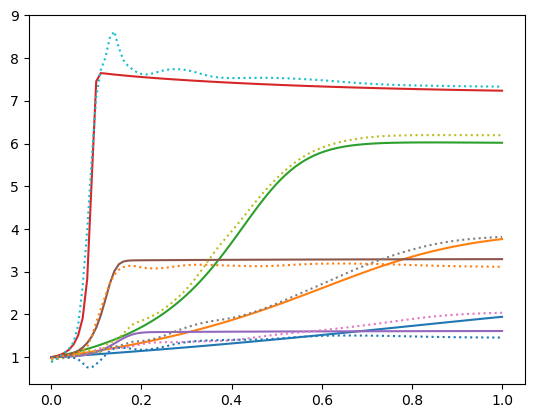

In [76]:
t = np.linspace(0, 1, 101, dtype=np.float32)
plt.plot(t, data_c[200:206].T)
plt.plot(t, pred_c[200:206].T, ':')
plt.show()


/var/folders/y5/mgf703t57tx9cwrbbjjvdzzr0000gr/T/ipykernel_31567/1080417616.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  rmserror = np.apply_along_axis(np.linalg.norm, 1, data_c - pred_c)
/var/folders/y5/mgf703t57tx9cwrbbjjvdzzr0000gr/T/ipykernel_31567/1080417616.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.hist(np.log10(rmserror), bins=np.linspace(-1.5,1,31))


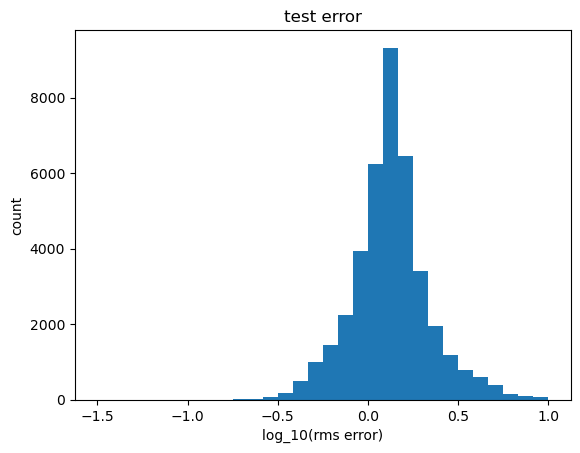

In [75]:
rmserror = np.apply_along_axis(np.linalg.norm, 1, data_c - pred_c)
plt.hist(np.log10(rmserror), bins=np.linspace(-1.5,1,31))
plt.xlabel('log_10(rms error)')
plt.ylabel('count')
plt.title('test error')
plt.show()

In [74]:
torch.save(model.state_dict(),'model_osm_deepo_size_80x80')